<a href="https://colab.research.google.com/github/KacperKaszuba0608/DE_analysis/blob/main/DE_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza DE (Differential Expression) wyników ze zliczenia odczytów

<p align=justify>
Poniższa analiza została przeprowadzona dla zmapowanych i zliczonych wyników próbek z BioProjeku "PRJNA313294".
Próbki dotyczyły Zika wirusa u człowieka. Zakażenie wirusem Zika (ZIKV), powracającym flawiwirusem i mikrocefalią, jest pilnym globalnym problemem zdrowotnym. Bezpośrednie komórki docelowe ZIKV w rozwijających się ludzkich płodach nie są jasne.
</p>

<p align=justify>
Przeprowadzono analizę różnic w ekspresji genów, aby sprawdzić, które geny ulegają ekspresji na różnych poziomach w różnych warunkach. Geny te mogą zapewnić biologiczny wgląd w procesy, na które wpływa stan zakażenia wirusem Zika. Z bazy <a href='https://www.ncbi.nlm.nih.gov/'>NCBI</a> pobrano w sumie 8 plików fastq dotyczących wspomnianego wcześniej projektu, następnie wykrzystano je jako pliki wsadowe dla wielu programów, które poprawiły jakość oraz przyrównały sekwencję do genomu referencyjnego. Dostęp do skryptu, który wykonuje przygotowanie pliku z wynikami do poniższej analizy znajduje się w repozytorium
GitHub pod nazwą <a href='https://github.com/KacperKaszuba0608/DE_analysis/blob/main/fastq_processing.sh'> fastq_processing.sh </a>.
</p>

Wykorzystano w nim narzędzia takie jak:
* `Entrez` - pobranie informacji o próbkach dotyczących wybranego projektu (PRJNA313294)
* `fastq-dump 2.10.0` - pobranie biopróbek o konkretnych numerach SRR i o zadanej przez użytkownika liczbie odczytów
* `FastQC v0.11.8` - sprawdzenie jakości odczytów
* `trimmomatic-0.39` - w celu usunięcia odczytów niskiej jakości
* `hisat2 2.1.0` - przyrównanie do sekwencji referencyjnej (hg19) [mapowanie]
* `samtools 1.9-216-g4c82d2c` - konwersja plików `sam` do `bam`
* `featureCounts v1.6.4` - zliczenie odczytów

Pobrane pliki to:
1. `SRR3191542_{1,2}.fastq` - Mock (pair end, kontrola)
2. `SRR3191543_{1,2}.fastq` - Mock (pair end, kontrola)
3. `SRR3191544_{1,2}.fastq` - ZIKV (pair end, zakażenie)
4. `SRR3191545_{1,2}.fastq` - ZIKV (pair end, zakażenie)
5. `SRR3194428_1.fastq` - Mock (single end, kontrola)
6. `SRR3194429_1.fastq` - Mock (single end, kontrola)
7. `SRR3194430_1.fastq` - ZIKV (single end, zakażenie)
8. `SRR3194431_1.fastq` - ZIKV (single end, zakażenie)

<p align=justify>
Pobrane pliki pochodził z dwóch urządzeń. Pliki sparowane (pair-end) zostały uzyskane za pomocą <b>Illumina MiSeq</b>, natomiast pliki pojedyncze (single-end) za pomocą <b>NextSeq 500</b>.
</p>

# Analiza statystyczna

Do analizy wykorzystano język programowania R 4.3.2 i pochodzących z niego bilbiotek: `DESeq2`, `pheatmap`, `ggfortify`, `ggplot2`.

In [ ]:
# Instalacja potrzebnych bibliotek
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
install.packages(c('ggfortify', 'pheatmap', 'ggplot2'))

In [ ]:
# Wczytanie potrzebnych bibliotek
library(DESeq2)
library(ggfortify)
library(pheatmap)

## Wczytanie i obróbka danych

In [23]:
df <- read.table("https://github.com/KacperKaszuba0608/DE_analysis/raw/main/counted_readings.txt", sep='\t', header=TRUE)
str(df)

'data.frame':	28265 obs. of  14 variables:
 $ Geneid                            : chr  "LOC102725121" "DDX11L1" "SPECC1L" "MIR6859-1" ...
 $ Chr                               : chr  "chr1;chr1;chr1;chr15;chr15;chr15" "chr1;chr1;chr1" "chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr"| __truncated__ "chr1;chr16;chr15" ...
 $ Start                             : chr  "11869;12613;13221;102516808;102518449;102518943" "11874;12613;13221" "24666785;24666785;24666799;24672668;24698163;24698163;24698163;24709281;24709281;24709281;24717256;24717256;247"| __truncated__ "17369;67052;102513727" ...
 $ End                               : chr  "12227;12721;14362;102517949;102518557;102519301" "12227;12721;14409" "24666951;24666951;24666951;24672771;24698352;24698352;24698352;24709434;24709434;24709434;24718886;24718886;247"| __truncated__ "17436;67119;102513794" ...
 $ Strand                            : chr  "+;+;+;-;-;-" "+;+;+" "+;+;+

Dane ze zliczenia odczytów zawierają wiele kolumn, które wyświetlono powyżej. Są to:
* `Geneid` - zawiera nazwy genów
* `Chr` - zawiera nazwę chromosomu, na którym znajduje się dany gen
* `Start` - zawiera całkowitą liczbę, którą jest pozycja startowa genu
* `End` - zawiera całkowitą liczbę, którą jest pozycja stop genu
* `Strand` - zawiera informację na której nici znajduje się gen (Forward [+]; Reverse [-])
* `Length` - zawiera całkowitą liczbę nienakładających się baz w eksonach należących do tego samego genu przed każdym genem
* `*.bam` - są to kolumny dla każdego analizowanego pliku `bam`, które zawierają informację o ilości zmapowanych w danym genie odczytów.

Kolejnym krokiem jest wyciągnięcie potrzebnych do analizy danych. W tym celu wybrano tylko wartości z kolumn `*.bam` oraz kolumnę `Geneid` w celu nazwania poszczególnych wierszy nazwami genów. Dodatkowo poprawiono nazwy kolumn, aby były bardziej informatywne.

In [43]:
# wyciągnięcie istotnych danych
count_data <- df[,7:14]
# zmiana nazw wierszy na nazwy genów
rownames(count_data) <- df$Geneid
# zmiana nazw kolumn na bardziej informatywne
matches <- regexpr("SRR(.*).", colnames(count_data), perl = TRUE)
colnames(count_data) <- unlist(strsplit(regmatches(colnames(count_data), matches), ".bam"))

Po odpowiednim przygotowaniu danych należy jeszcze stworzyć odpowiednie obiety wsadowe do funkcji `DESeqDataSetFromMatrix()`, która służy do przechowywania wartości wejściowych, obliczeń pośrednich i wyników analizy ekspresji różnicowej. Poniżej widzimy produkt wyjściowy połączenia nazw plików `bam` z odpowiednimy ich opisami to znaczy, które z nich to kontrola (Mock), a które są zakażone (ZIKV).

In [44]:
# Przygotowanie wektora nazw plików BAM
samples <- names(count_data)

# przygotowanie tabeli do wczytania danych do DESeq2
cond1 <- rep('Mock', 2)
cond2 <- rep('ZIKV', 2)
condition <- factor(c(cond1, cond2, cond1, cond2))
colData <- data.frame(samples=samples, condition=condition)
colData

samples,condition
<chr>,<fct>
SRR3191542,Mock
SRR3191543,Mock
SRR3191544,ZIKV
SRR3191545,ZIKV
SRR3194428,Mock
SRR3194429,Mock
SRR3194430,ZIKV
SRR3194431,ZIKV


## Przygotowanie danych do normalizacji oraz analizy DE

<p align=justify>
Następnym krokiem jest wykorzystanie wcześniej wspomnianej funkcji na przygotowanych obiektach <b>count_data</b>, <b>colData</b> oraz <b>condition</b>. Po wczytaniu danych do biblioteki DESeq2 obliczono współczynnik skalowania, który musi uwzględniać różnice w "głębokość sekwencjonowania" oraz różnice w kompozycji biblioteki.
</p>

In [45]:
# wczytanie danych do bilbioteki DESeq2
dds <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = colData,
                              design = ~condition)

# obliczanie współczynnika skalowania
dds1 <- estimateSizeFactors(dds)
data.frame(SF=dds1$sizeFactor,
           Group=condition,
           Instrument=c(rep('MiSeq',4), rep('NextSeq 500',4)))

,SF,Group,Instrument
,<dbl>,<fct>,<chr>
SRR3191542,2.2765713,Mock,MiSeq
SRR3191543,2.5062992,Mock,MiSeq
SRR3191544,2.6172438,ZIKV,MiSeq
SRR3191545,2.0162110,ZIKV,MiSeq
SRR3194428,0.4644844,Mock,NextSeq 500
SRR3194429,0.4192226,Mock,NextSeq 500
SRR3194430,0.4385514,ZIKV,NextSeq 500
SRR3194431,0.4431787,ZIKV,NextSeq 500


<p align=justify>
Z powyższej tabeli można wywnioskować, że urządzenie MiSeq ma mniejszą bibliotekę (duża wartość SF), jednakże idzie za tym wyższe dopasowanie do rozkładu normalnego - większy wpływ normalizacji na wynik ekspresji. Warto również zauważyć, że odczyty obu badanych grup są podobnej ekspresji nie zależnie od urządzenia. <br>
Kolejnym krokiem analizy jest przeprowadzenie normalizacji i wizualizacja wyników za pomocą <b>heatmapy</b> oraz <b>analizy PCA</b>.
</p>

## Wyniki normalizacji

In [ ]:
# normalizacja danych
log_data <- rlog(dds)
norm_data <- assay(log_data)
norm_data <- as.data.frame(norm_data)

<p align=justify>
Na podstawie poniższego wykresu przedstawiającego geny z ekspresją wyższą niż 4 można stwierdzić, że geny EEF1A1, ACTG1 oraz TUBA1A mają lepszą ekspresję w większości próbkach. Ekspresja genu MAP1B jest wyższa od pozostałych w próbce SRR3194431, może to oznaczać jakąś specyficzność związaną z zakażeniem ZIKV. Natomiast gen WSB1 ma o wiele wyższą ekspresję we wszystkich próbkach kontrolnych. Pozostałe geny mają prównywalną ekspresję we wszystkich badanych próbkach.
</p>

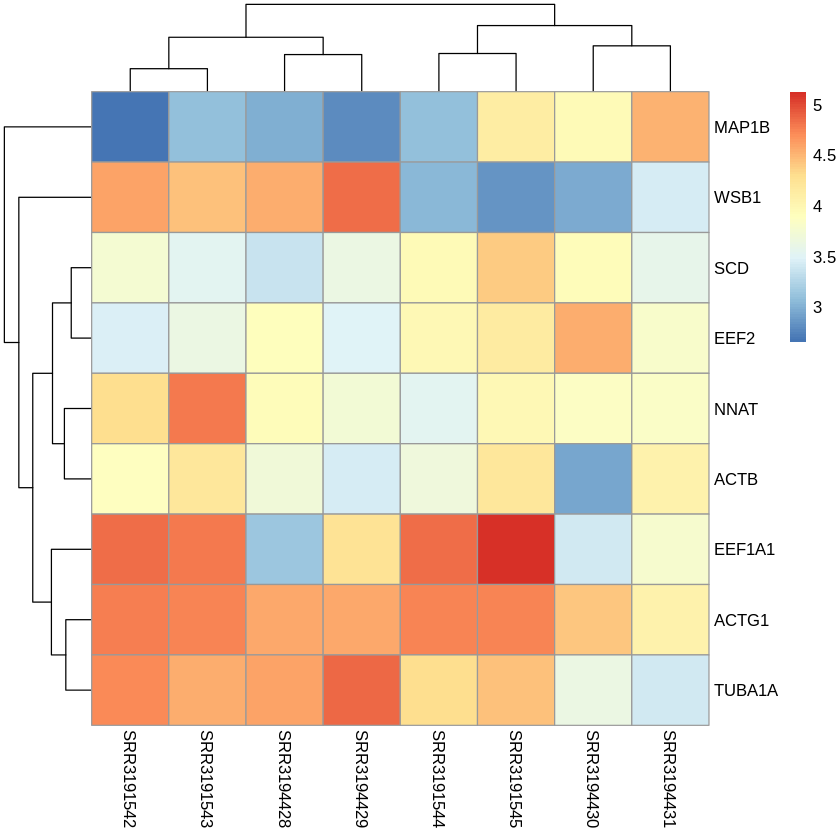

In [47]:
# przygotowanie danych do heatmapy z wyższą ekspresją (>= 4)
hm_df <- norm_data[apply(norm_data, 1, function(x) sum(x >= 4) > 0),]

# heatmap
pheatmap(hm_df)

<p align=justify>
Wyniki analizy PCA (wykres poniżej) pokazały, że geny SCD, EEF2, NNAT oaz ACTB mają podobną ekspresję we wszystkich próbkach nie zależnie od grupy. Ekspresja genów ACTG1 oraz EEF1A1 są poodbne i tworzą jedną grupę. Natomiast ekspresja genów WSB1, MAP1B oraz TUBA1a nie jest skorelowana z pozostałymi.
</p>

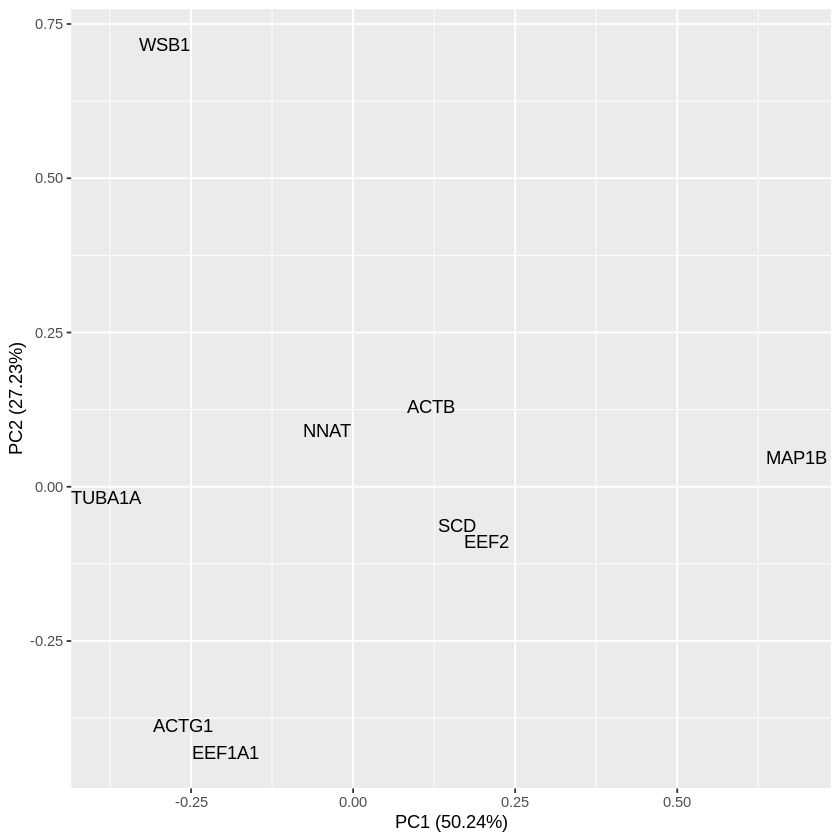

In [13]:
# PCA
pca_res <- prcomp(hm_df, scale=TRUE)

ggplot2::autoplot(pca_res, label=TRUE, shape=FALSE)

## Sprawdzenie istotności ekspresji

In [ ]:
# Obliczanie DE
dds <- DESeq(dds, quiet = FALSE)
res <- results(dds)

# wyrzucamy rekordy, które mają ekspresję równą 0
res <- res[res$baseMean != 0,]

# Zachowujemy rekordy, których ekspresja jest 2-krotnie większa
res <- res[res$log2FoldChange > 1 | res$log2FoldChange < -1,]

# Filtrujemy rekordy i zostawiamy te, która mają wartości padj (adjasted p-value)
res <- res[!is.na(res$padj),]

# Wybieramy wiersze, których padj jest mniejsze od 0.05 (poziom istotności)
res <- res[res$padj < 0.05,]

In [19]:
# dane po filtracji
res

log2 fold change (MLE): condition ZIKV vs Mock 
Wald test p-value: condition ZIKV vs Mock 
DataFrame with 1 row and 6 columns
      baseMean log2FoldChange     lfcSE      stat      pvalue      padj
     <numeric>      <numeric> <numeric> <numeric>   <numeric> <numeric>
WSB1   17.7125       -2.14851  0.437643  -4.90927 9.14167e-07 0.0076077

<p align=justify>
Powyższy wynik wskazuje, że jedynie gen WSB1 ma istotną statystycznie ekspresję w analizowanych próbkach. W tym przypadku można by było stwierdzić, że obniżona ekspresja genu WSB1 ma potencjalny związek z zakażeniem wirusem ZIKV.
</p>

# LITERATURA

[1] Wei Shiand and Yang Liao; "Rsubread/Subread Users Guide"; 20 February 2023, Olivia Newton-John Cancer Research Institute; Melbourne,Australia; dostęp z 7.02.2024; url=https://subread.sourceforge.net/SubreadUsersGuide.pdf

[2] Tang H et al., "Zika Virus Infects Human Cortical Neural Progenitors and Attenuates Their Growth.", Cell Stem Cell, 2016 May 5;18(5):587-90, https://doi.org/10.1016/j.stem.2016.02.016